In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [5]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
prf = prf.join(abundances, ['sample type', 'sample'])

In [6]:
prf = prf[(prf['sample type'] != 'single-strain') &
          (prf['sample type'] != 'sterile-water-blank') &
          (prf['sample type'] != 'mock-community') &
          (prf['sample type'] != 'plant-surface')]
prf = prf[prf['method'] == 'weighted']

In [7]:
grouped = prf.groupby(['sample type', 'class weights', 'level'])
def weighted_stats(x):
    d1 = DescrStatsW(x['F-measure'], weights=x['abundance'])
    lower, upper = d1.tconfint_mean()
    return Series([d1.mean, lower, upper], index=['mean', 'lower', 'upper'])
figure4 = grouped.apply(weighted_stats)
figure4.reset_index(inplace=True)
old_labels = 'plant-corpus', 'background', 'uniform70', 'bespoke70'
new_labels = 'Wrong', 'Average', 'Uniform', 'Bespoke'
for old, new in zip(old_labels, new_labels):
    figure4.loc[figure4['class weights'] == old, 'class weights'] = new

In [40]:
figure4.loc[(figure4['sample type'] == 'Plant corpus') &
            (figure4['class weights'] == 'Wrong'), 'mean'] = None
figure4.loc[(figure4['sample type'] == 'Plant corpus') &
            (figure4['class weights'] == 'Wrong'), 'lower'] = None
figure4.loc[(figure4['sample type'] == 'Plant corpus') &
            (figure4['class weights'] == 'Wrong'), 'upper'] = None

In [41]:
%%R -i figure4

cbPalette <- c("#999999", "#56B4E9", "#E69F00", "#009E73", "#F0E442", "#0072B2", "#D55E00")

figure4$class.weights = factor(figure4$class.weights, levels=c(
    'Wrong', 'Average', 'Uniform', 'Bespoke'
))
ggplot(figure4, aes(x=level, y=mean, 
                    group=interaction(sample.type, class.weights),
                    colour=class.weights)) + 
geom_line(alpha=0.3) + 
geom_smooth(aes(group=class.weights), method='loess', se=FALSE) + 
theme_bw() +
  labs(y='F-measure', x='Taxonomy Level') +
  scale_colour_manual(values=cbPalette) +
  guides(colour=guide_legend(title="Taxonomic Weights", reverse=T)) +
scale_x_continuous(breaks=c(1, 2, 3, 4, 5, 6, 7),
        labels=c(    'Kingdom',
    'Phylum',
    'Class',
    'Order',
    'Family',
    'Genus',
    'Species')) + 
theme(axis.text.x = element_text(angle = 30, vjust=1, hjust=1))

ggsave(file="figure4.png", width=5, height=5, dpi=300)

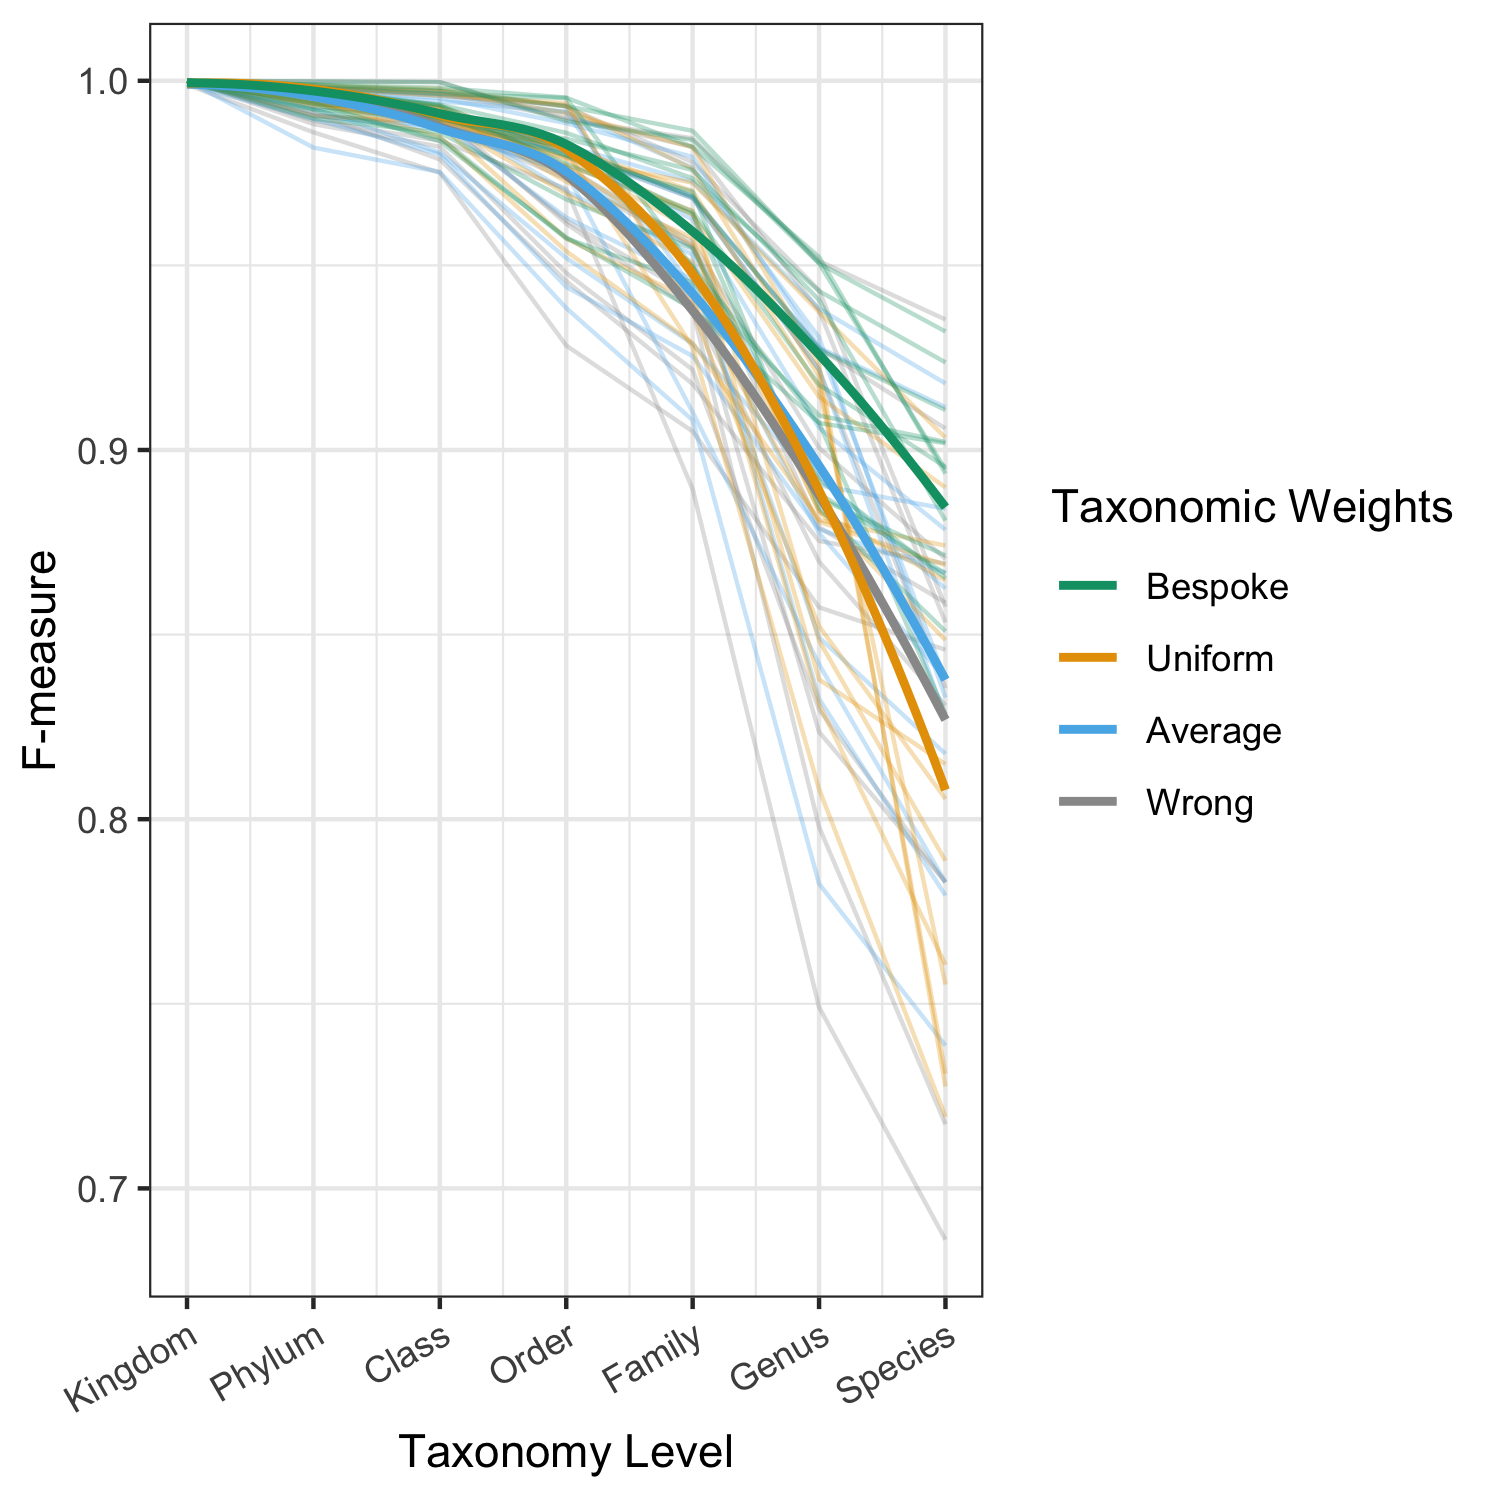

In [42]:
Image("figure4.png")